# Credit Card Approval Prediction


## Context

Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.

Generally speaking, credit score cards are based on historical data. Once encountering large economic fluctuations. Past models may lose their original predictive power. Logistic model is a common method for credit scoring. Because Logistic is suitable for binary classification tasks and can calculate the coefficients of each feature. In order to facilitate understanding and operation, the score card will multiply the logistic regression coefficient by a certain value (such as 100) and round it.

At present, with the development of machine learning algorithms. More predictive methods such as Boosting, Random Forest, and Support Vector Machines have been introduced into credit card scoring. However, these methods often do not have good transparency. It may be difficult to provide customers and regulators with a reason for rejection or acceptance.

## Task

Build a machine learning model to predict if an applicant is 'good' or 'bad' client, different from other tasks, the definition of 'good' or 'bad' is not given. You should use some techique, such as vintage analysis to construct you label. Also, unbalance data problem is a big problem in this task.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
import pickle

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_palette(sns.color_palette("Paired"))

In [3]:
# There are 2 datasets 

# 1. application records (contains all information about the applicants)

application_records = pd.read_csv('../../data/raw/application_record.csv')

# 2. credit records (contains information about the loan and depth)

credit_records = pd.read_csv('../../data/raw/credit_record.csv')

# 1. Exploratory Data Analysis

In [4]:
display(application_records.head())
display(credit_records.head())

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
# Standardizing the column names for both files: 

def columns(x):
    return x.lower()

application_records.columns = list(map(columns, application_records.columns))
credit_records.columns = list(map(columns, credit_records.columns))


In [6]:
# Checking if the data of the two files match in length: 

print('Application Records = {}'.format(application_records.shape))
print('Credit Records = {}'.format(credit_records.shape))

#There is a big difference in data length in the two files

Application Records = (438557, 18)
Credit Records = (1048575, 3)


## 1.1 Target Feature

**Column Status:** 

- 0: 1-29 days past due
- 1: 30-59 days past due
- 2: 60-89 days overdue
- 3: 90-119 days overdue
- 4: 120-149 days overdue
- 5: Overdue or bad debts, write-offs for more than 150 days
- C: paid off that month
- X: No loan for the month



**Column Months_Balance:**

The month of the extracted data is the starting point, backwards

- 0: current month
- -1: previous month
- ...


In [7]:
print(credit_records.shape)
credit_records['id'].nunique()

(1048575, 3)


45985

In [8]:
credit_records['status'].value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: status, dtype: int64

<AxesSubplot:xlabel='status', ylabel='count'>

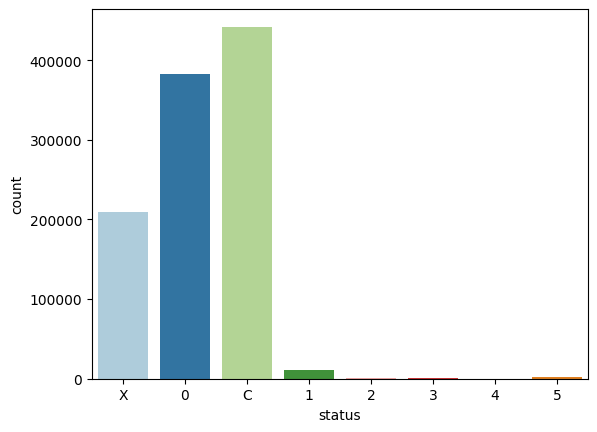

In [9]:
sns.countplot(credit_records['status'])

### Engineering Target Feature

In [10]:
pivot_tb = pd.pivot_table(credit_records, index = ['id', 'status'], aggfunc = 'count').reset_index()
pivot_tb

,id,status,months_balance
0,5001711,0,3
1,5001711,X,1
2,5001712,0,10
3,5001712,C,9
4,5001713,X,22
...,...,...,...
94138,5150483,X,18
94139,5150484,0,12
94140,5150484,C,1
94141,5150485,0,2


In [11]:
# Find percentage of customers for each status

ratio_overdue = []

# ratio of customers overdue more than 1 day:
overdue0 = round(len(pivot_tb[pivot_tb['status'] == '0']) / pivot_tb['id'].nunique(), 3)
ratio_overdue.append(overdue0)

# ratio of customers overdue more than 30 days:
overdue1 = round(len(pivot_tb[pivot_tb['status'] == '1']) / pivot_tb['id'].nunique(), 3)
ratio_overdue.append(overdue1)

# ratio of customers overdue more than 60 day:
overdue2 = round(len(pivot_tb[pivot_tb['status'] == '2']) / pivot_tb['id'].nunique(), 4)
ratio_overdue.append(overdue2)

# ratio of customers overdue more than 90 day:
overdue3 = round(len(pivot_tb[pivot_tb['status'] == '3']) / pivot_tb['id'].nunique(), 4)
ratio_overdue.append(overdue3)
                     
# ratio of customers overdue more than 120 day:
overdue4 = round(len(pivot_tb[pivot_tb['status'] == '4']) / pivot_tb['id'].nunique(), 5)
ratio_overdue.append(overdue4)

# ratio of customers overdue more than 150 day:
overdue5 = round(len(pivot_tb[pivot_tb['status'] == '5']) / pivot_tb['id'].nunique(), 5)
ratio_overdue.append(overdue5)

ratio_overdue = ['{0:.2f}%'.format(val * 100) for val in ratio_overdue]
ratio_overdue

['86.90%', '11.30%', '1.30%', '0.58%', '0.41%', '0.42%']

In [12]:
# Creating a Dictonary and a Dataframe out of the caculated ratio.

dict = {'days overdue': ['more than 1', 'more than 30', 'more than 60', 'more than 90', 'more than 120', 'more than 150'], 
       'ratio': ratio_overdue}

ratio_status = pd.DataFrame.from_dict(dict)
ratio_status

,days overdue,ratio
0,more than 1,86.90%
1,more than 30,11.30%
2,more than 60,1.30%
3,more than 90,0.58%
4,more than 120,0.41%
5,more than 150,0.42%


The percentage of customers who are overdue more than 1 day lies by 87%. If we would consider customers with STATUS 0 as RISK Customers this would lead to a lot of people being classified as bad. Those would not receive a loan. However the bank would also loose a lot of profit by being too risk averse. 

Considering the customers with more than 30 day overdue also leads to a relative high amount of customers classified as bad. More than 10% of customers are overdue more than 30days at least once. 

Customers overdue more than 60 days are already at a reasonable percentag of 1.3% 

**APPROACHE: 


In [13]:
# Approach for Labeling: 
credit = credit_records.copy() 

# Grouping the classes together in GOOD, NEUTRAL and BAD
rename = {'X': 'Good', 'C': 'Good', '0': 'Good', '1': 'Neutral', '2': 'Bad', '3': 'Bad', '5': 'Bad'}

# renaming the status with the group names
credit['status'] = credit['status'].map(rename)
credit.head(2)

,id,months_balance,status
0,5001711,0,Good
1,5001711,-1,Good


In [14]:
# Grouping the counts of each Status per customer

flag = credit.groupby(['id', 'status'])['status'].count().unstack(fill_value=0)
flag.head()

status,Bad,Good,Neutral
id,,,
5001711,0,4,0
5001712,0,19,0
5001713,0,22,0
5001714,0,15,0
5001715,0,60,0


In [15]:
# Customers which have more NEUTRAL than GOOD records will be classified as 1: 'not approved'
# Customers which have one BAD status will be automatically classified as 1: 'not approved'
# Customers which have more GOOD than NEUTRAL will be calssified as 0: 'approved'

flag.loc[flag['Neutral'] >= flag['Good'], 'flag'] = 1
flag.loc[flag['Good'] > flag['Neutral'], 'flag'] = 0
flag.loc[flag['Bad'] > 0, 'flag'] = 1

In [16]:
# saving the dendend variable in a df
var_dep = flag.drop(['Bad', 'Good', 'Neutral'], axis = 1)

0.0    45241
1.0      744
Name: flag, dtype: int64

There is a big Class Imbalance in the data: 



<AxesSubplot:xlabel='flag', ylabel='count'>

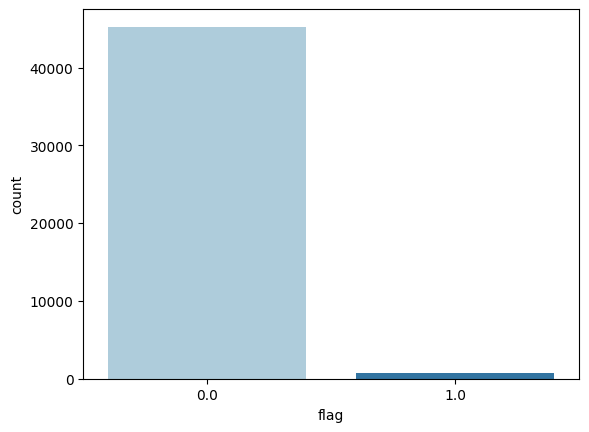

In [17]:
#CLASS IMBALANCE
print(var_dep['flag'].value_counts())
print()
print('There is a big Class Imbalance in the data: \n')
sns.countplot(x = var_dep['flag'])


In [18]:
# Combining the information of target variable with independen variables: 

application = pd.merge(var_dep, application_records, on ='id')
application.to_csv('../../slides/application_target.csv')

## 1.2 Independent Features

In [19]:
application.head()

,id,flag,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members
0,5008804,0.0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,0.0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,0.0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,0.0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,0.0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [20]:
# Are the columns in the correct dtype

application.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   36457 non-null  int64  
 1   flag                 36457 non-null  float64
 2   code_gender          36457 non-null  object 
 3   flag_own_car         36457 non-null  object 
 4   flag_own_realty      36457 non-null  object 
 5   cnt_children         36457 non-null  int64  
 6   amt_income_total     36457 non-null  float64
 7   name_income_type     36457 non-null  object 
 8   name_education_type  36457 non-null  object 
 9   name_family_status   36457 non-null  object 
 10  name_housing_type    36457 non-null  object 
 11  days_birth           36457 non-null  int64  
 12  days_employed        36457 non-null  int64  
 13  flag_mobil           36457 non-null  int64  
 14  flag_work_phone      36457 non-null  int64  
 15  flag_phone           36457 non-null 

### Missing Values 

In [21]:
application.isna().sum()
null_values = pd.DataFrame(application.isna().sum())
null_values

,0
id,0
flag,0
code_gender,0
flag_own_car,0
flag_own_realty,0
cnt_children,0
amt_income_total,0
name_income_type,0
name_education_type,0
name_family_status,0


In [22]:
# Looking into the occupation type colume to check how we can deal with the missing values
occupation_type_original = pd.DataFrame(application['occupation_type'].value_counts( dropna = False))
occupation_type_original

,occupation_type
NaN,11323
Laborers,6211
Core staff,3591
Sales staff,3485
Managers,3012
Drivers,2138
High skill tech staff,1383
Accountants,1241
Medicine staff,1207
Cooking staff,655


In [23]:
# Fill Missing Values: 

application['occupation_type'] = application['occupation_type'].fillna('Others')
application['occupation_type'].value_counts( dropna = False)

Others                   11323
Laborers                  6211
Core staff                3591
Sales staff               3485
Managers                  3012
Drivers                   2138
High skill tech staff     1383
Accountants               1241
Medicine staff            1207
Cooking staff              655
Security staff             592
Cleaning staff             551
Private service staff      344
Low-skill Laborers         175
Waiters/barmen staff       174
Secretaries                151
HR staff                    85
Realty agents               79
IT staff                    60
Name: occupation_type, dtype: int64

### Categorical Features

In [24]:
# Selecting the categorical values

application_cat = application.select_dtypes('object')
application_cat['id'] = application.loc[:, 'id'] #inlcuding ID to be able to match df together again

# Selecting the numerical values
application_num = application.select_dtypes(np.number)

#### Reducing & Merging Classes

In [25]:
# checking for the amount of classes in each feature
application_cat.nunique()

code_gender                2
flag_own_car               2
flag_own_realty            2
name_income_type           5
name_education_type        5
name_family_status         5
name_housing_type          6
occupation_type           19
id                     36457
dtype: int64

Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: name_income_type, dtype: int64

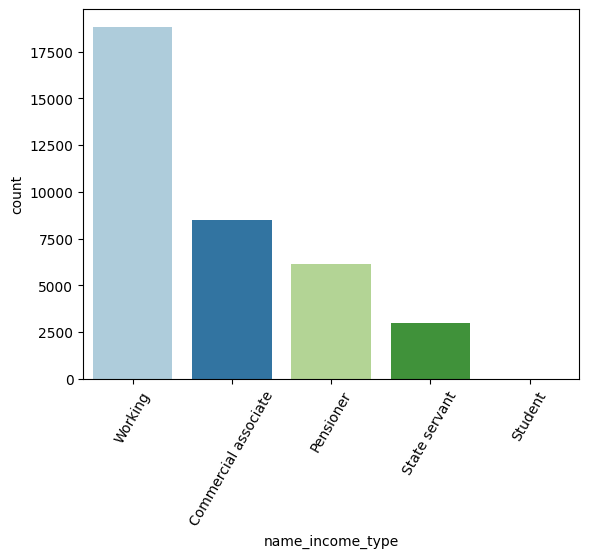

In [26]:
# checking the frequency of classes in INCOME TYPE

plot = sns.countplot(application_cat['name_income_type'])
plot.set_xticklabels(plot.get_xticklabels(), rotation = 60)
application_cat['name_income_type'].value_counts()


Working                 18819
Commercial associate     8490
Others                   6163
State servant            2985
Name: name_income_type, dtype: int64

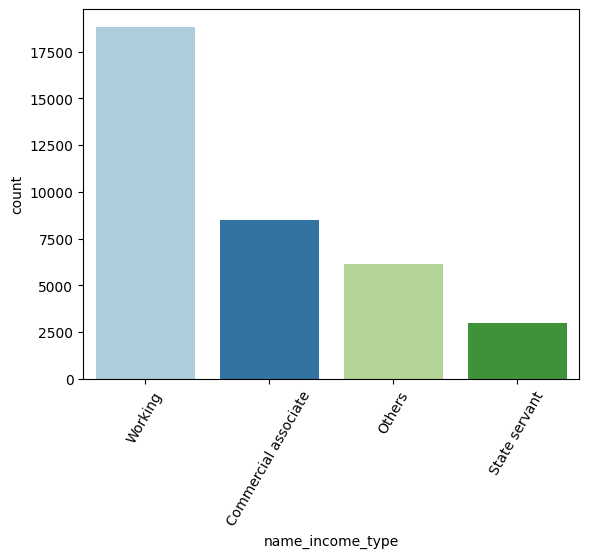

In [27]:
# I will merge 'Student' and 'Pensioner' 
application_cat.loc[(application_cat['name_income_type'] == 'Student') | (application_cat['name_income_type'] == 'Pensioner'), 'name_income_type'] = 'Others'
plot = sns.countplot(application_cat['name_income_type'])
plot.set_xticklabels(plot.get_xticklabels(), rotation = 60)
application_cat['name_income_type'].value_counts()


Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: name_education_type, dtype: int64

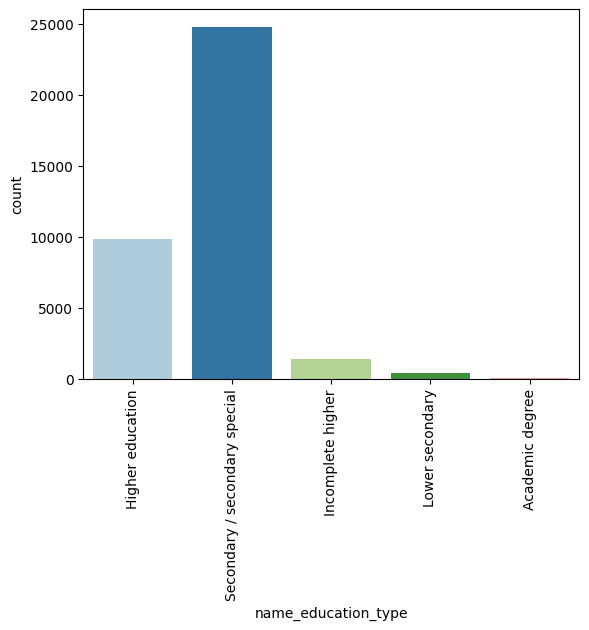

In [28]:
# checking the frequency of classes in INCOME TYPE
plot = sns.countplot(application_cat['name_education_type'])
plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
application_cat['name_education_type'].value_counts()


Secondary education    25151
Higher education        9896
Incomplete higher       1410
Name: name_education_type, dtype: int64

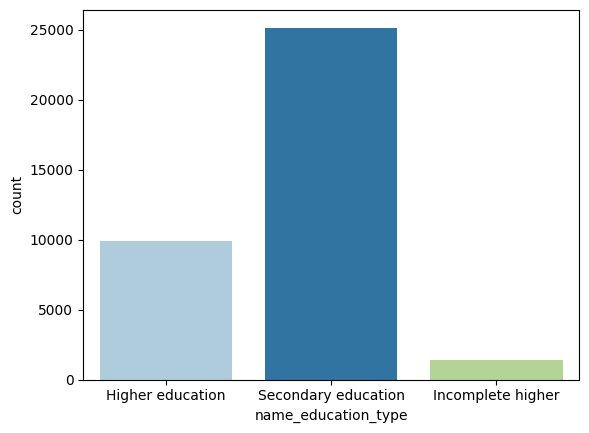

In [29]:
# I will merge all classes containing 'SECONDARY' and 'HIGHER' 

application_cat.loc[(application_cat['name_education_type'] == 'Lower secondary') | (application_cat['name_education_type'] == 'Secondary / secondary special'), 'name_education_type'] = 'Secondary education'
application_cat.loc[(application_cat['name_education_type'] == 'Academic degree'), 'name_education_type'] = 'Higher education'
sns.countplot(application_cat['name_education_type'])
application_cat['name_education_type'].value_counts()

Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: name_family_status, dtype: int64

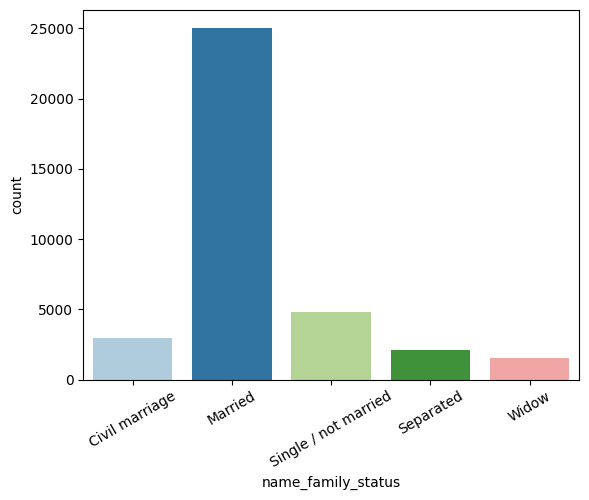

In [30]:
# checking frequency of classes in FAMILY STATUS
plot = sns.countplot(application_cat['name_family_status'])
plot.set_xticklabels(plot.get_xticklabels(), rotation = 30)
application_cat['name_family_status'].value_counts()

Married        27993
Not Married     8464
Name: name_family_status, dtype: int64

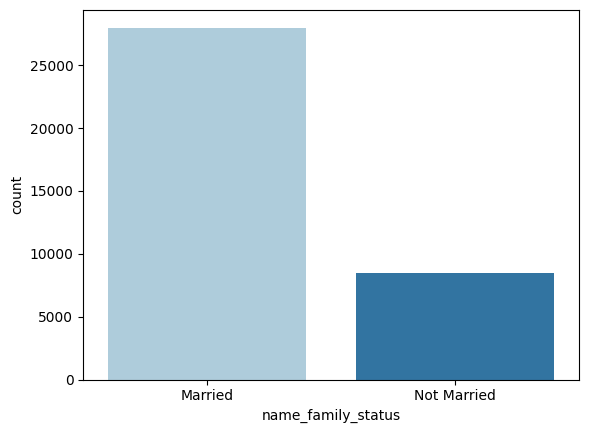

In [31]:
# I will group to 2 classes 'Married' and 'Not Married'
application_cat.loc[(application_cat['name_family_status'] == 'Civil marriage'), 'name_family_status'] = 'Married'
application_cat.loc[(application_cat['name_family_status'] != 'Married'), 'name_family_status'] = 'Not Married'
sns.countplot(application_cat['name_family_status'])
application_cat['name_family_status'].value_counts()

House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: name_housing_type, dtype: int64

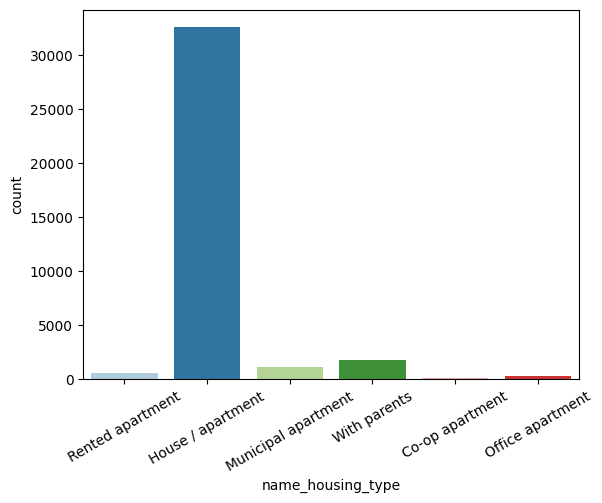

In [32]:
# checking frequency of classes in HOUSING TYPE
plot = sns.countplot(application_cat['name_housing_type'])
plot.set_xticklabels(plot.get_xticklabels(), rotation = 30)
plt.show
application_cat['name_housing_type'].value_counts()

House / apartment    32548
Rented apartment      2133
With parents          1776
Name: name_housing_type, dtype: int64

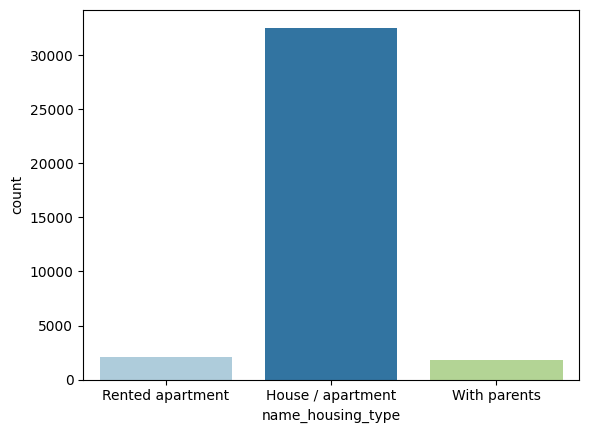

In [33]:
application_cat.loc[(application_cat['name_housing_type'] == 'Municipal apartment') | (application_cat['name_housing_type'] == 'Office apartment') |
                    (application_cat['name_housing_type'] == 'Office apartment') | 
                    (application_cat['name_housing_type'] == 'Co-op apartment'), 'name_housing_type'] = 'Rented apartment'
sns.countplot(application_cat['name_housing_type'])
application_cat['name_housing_type'].value_counts()

Others                   11323
Laborers                  6211
Core staff                3591
Sales staff               3485
Managers                  3012
Drivers                   2138
High skill tech staff     1383
Accountants               1241
Medicine staff            1207
Cooking staff              655
Security staff             592
Cleaning staff             551
Private service staff      344
Low-skill Laborers         175
Waiters/barmen staff       174
Secretaries                151
HR staff                    85
Realty agents               79
IT staff                    60
Name: occupation_type, dtype: int64

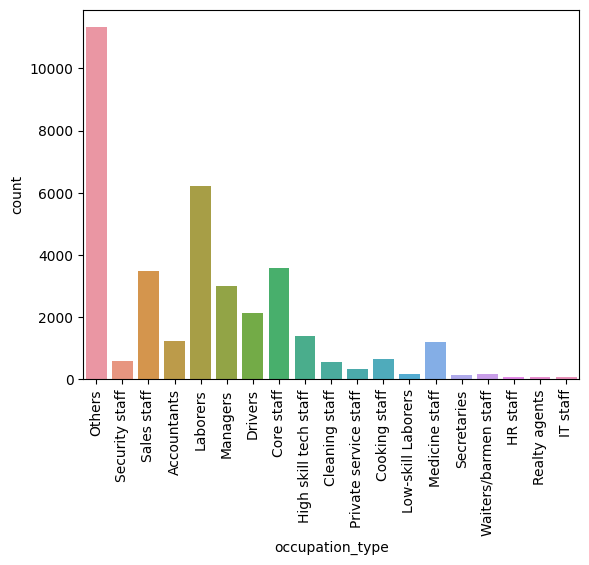

In [34]:
# checking frequency of classes in OCCUPATION
plot = sns.countplot(application_cat['occupation_type'])
plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
application_cat['occupation_type'].value_counts()

Others          11323
Laborers        10840
Core staff       9193
Office Staff     5101
Name: occupation_type, dtype: int64

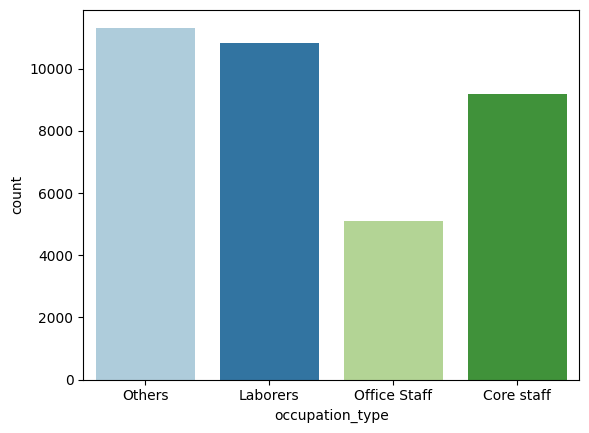

In [35]:
# Grouping into 3 classes: Others, Laborers, Core Staff


application_cat.loc[(application_cat['occupation_type'] == 'Drivers') | (application_cat['occupation_type'] == 'Cooking staff') | 
                    (application_cat['occupation_type'] == 'Security staff') | (application_cat['occupation_type'] == 'Cleaning staff') |
                    (application_cat['occupation_type'] == 'Private service staff') | (application_cat['occupation_type'] == 'Low-skill Laborers') |
                    (application_cat['occupation_type'] == 'Waiters/barmen staff'), 'occupation_type'] = 'Laborers'

application_cat.loc[(application_cat['occupation_type'] == 'IT staff') | (application_cat['occupation_type'] == 'Sales staff') |
                    (application_cat['occupation_type'] == 'HR staff') | (application_cat['occupation_type'] == 'Secretaries') |
                    (application_cat['occupation_type'] == 'Realty agents') | (application_cat['occupation_type'] == 'Accountants'), 'occupation_type'] = 'Office Staff'

application_cat.loc[(application_cat['occupation_type'] == 'Core staff') | (application_cat['occupation_type'] == 'Managers') |
                    (application_cat['occupation_type'] == 'High skill tech staff') | 
                    (application_cat['occupation_type'] == 'Medicine staff'), 'occupation_type'] = 'Core staff'

plot = sns.countplot(application_cat['occupation_type'])
application_cat['occupation_type'].value_counts()

#### Two-sample T-Test
I want to check if my classes in Occupation makes sense: Therefore i will test if there is a difference between the incomes in the groups. 

**Assumption: if the classification is correct, than this should be reflected in the income.** I want to see, if Core Staff has higher pay than the rest. 

TWO SAMPLE RIGHT TAIL T-TEST:

-  H0: There is no difference between the income mean 
-  H1: The income mean of the Core Staff is higher
-  lambda: 0.05






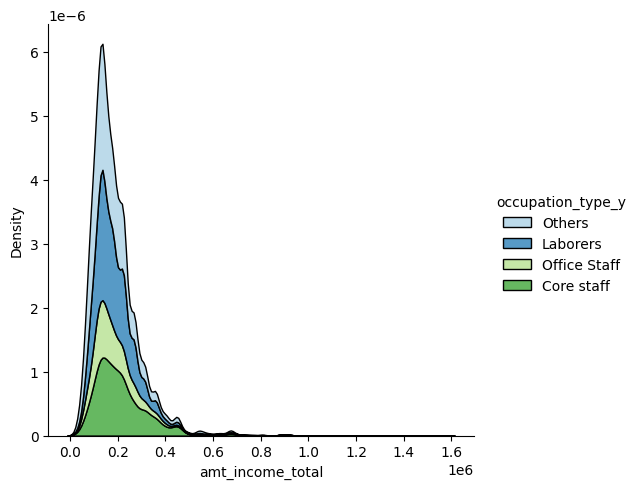

In [36]:
data = application.merge(application_cat, on='id')
income = pd.DataFrame(data['amt_income_total'])
ot = pd.DataFrame(data['occupation_type_y'])
data = pd.concat([income, ot], axis = 1)
sns.displot(data, x='amt_income_total', hue = 'occupation_type_y', kind='kde', multiple="stack")

In [37]:
# CHECK IF VARIANCES ARE EQUAL. IF LARGE TO SMALL RATIO IS < 4:1

# EQUALE VARIANCE:
income_core = application.loc[(application['occupation_type'] == 'Core staff') | (application['occupation_type'] == 'Managers') |
                    (application['occupation_type'] == 'High skill tech staff') | 
                    (application['occupation_type'] == 'Medicine staff'), 'amt_income_total']

income_others = application.loc[(application['occupation_type'] == 'Others') | (application['occupation_type'] == 'Drivers') | (application['occupation_type'] == 'Cooking staff') | 
                    (application['occupation_type'] == 'Security staff') | (application['occupation_type'] == 'Cleaning staff') |
                    (application['occupation_type'] == 'Private service staff') | (application['occupation_type'] == 'Low-skill Laborers') |
                    (application['occupation_type'] == 'Waiters/barmen staff') | (application['occupation_type'] == 'IT staff') | (application['occupation_type'] == 'Sales staff') |
                    (application['occupation_type'] == 'HR staff') | (application['occupation_type'] == 'Secretaries') |
                    (application['occupation_type'] == 'Realty agents') | (application['occupation_type'] == 'Accountants'), 'amt_income_total']


In [38]:
print(np.var(income_others), np.var(income_core))
print('\nThe Ratio of both sample variances is {:.2f} which is smaller than 4:1'.format(np.var(income_core)/np.var(income_others)))
print('We can assume that the variances are the same')


# CALCULATING THE MEANS:
bar_core = round(np.mean(income_core))
bar_others = round(np.mean(income_others))
print()
print('The income mean of Core Staff {} is bigger than the income mean of the others group {}'.format(bar_core, bar_others))


# PERFORMING TWO SAMPLE T-TEST:
from scipy.stats import ttest_ind
tval, pval = ttest_ind(a=income_core, b=income_others, equal_var=True)
print('\nThe p-value is very small {}: \nThe income seems to be signficantly different from each other'.format(pval))

8640220983.375156 16778670379.837515

The Ratio of both sample variances is 1.94 which is smaller than 4:1
We can assume that the variances are the same

The income mean of Core Staff 217041 is bigger than the income mean of the others group 168599

The p-value is very small 6.988673474252292e-208: 
The income seems to be signficantly different from each other


### Numerical Values

In [39]:
application_num = application.select_dtypes(np.number)
application_num.head()
application_num.to_csv('../../slides/numerical_before.csv')

In [40]:
# Moving FLAG Values from numerical to categorical df:

application_cat = application_cat.assign(flag_mobil = application_num['flag_mobil'],
                      flag_work_phone = application_num['flag_work_phone'],
                      flag_phone = application_num['flag_phone'],
                      flag_email = application_num['flag_email'])

#### Dealing with Outliers

<AxesSubplot:xlabel='cnt_fam_members', ylabel='count'>

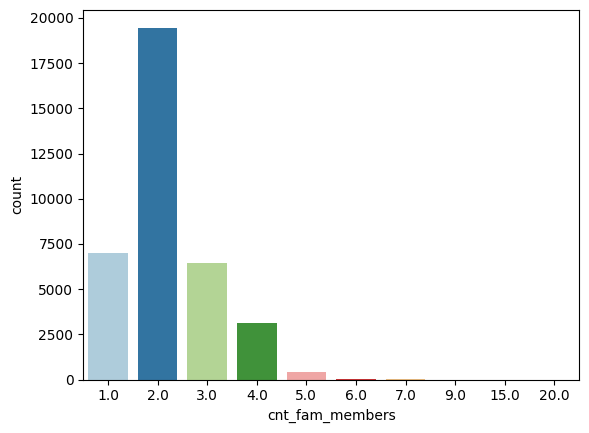

In [41]:
# FAMILY MEMBERS

sns.countplot(application_num['cnt_fam_members'])


<AxesSubplot:xlabel='cnt_fam_members'>

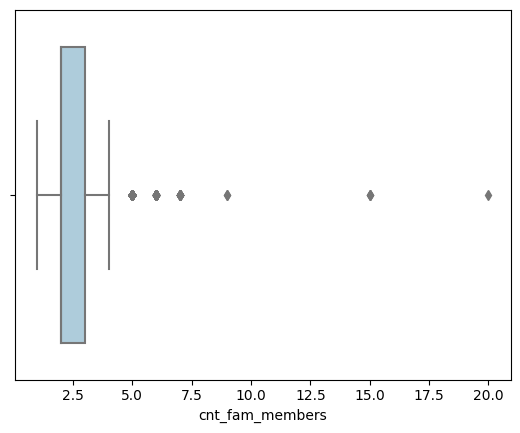

In [42]:
sns.boxplot(x = application_num['cnt_fam_members'])

In [43]:
application_num['cnt_fam_members'].value_counts()

2.0     19463
1.0      6987
3.0      6421
4.0      3106
5.0       397
6.0        58
7.0        19
15.0        3
9.0         2
20.0        1
Name: cnt_fam_members, dtype: int64

In [44]:
# AGE
import math
application_num['age'] = -application_num['days_birth'] / 365 # changing age value from -days to years
application_num['age'] = application_num['age'].apply(lambda x: math.floor(x))

In [45]:
application_num.drop('days_birth', axis = 1, inplace = True)

<AxesSubplot:xlabel='age'>

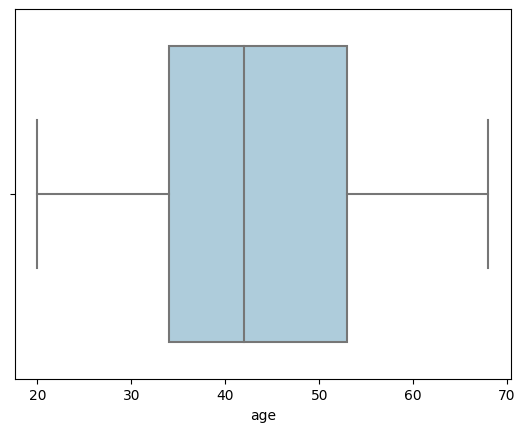

In [46]:
sns.boxplot(x = application_num['age'])

In [47]:
# EMPLOYEED

application_num['employed_since'] = -application_num['days_employed'] / 365 #changing working days from -days to years
application_num['employed_since'] = application_num['employed_since'].apply(lambda x: math.floor(x))

In [48]:
application_num.shape

(36457, 12)

<AxesSubplot:xlabel='employed_since'>

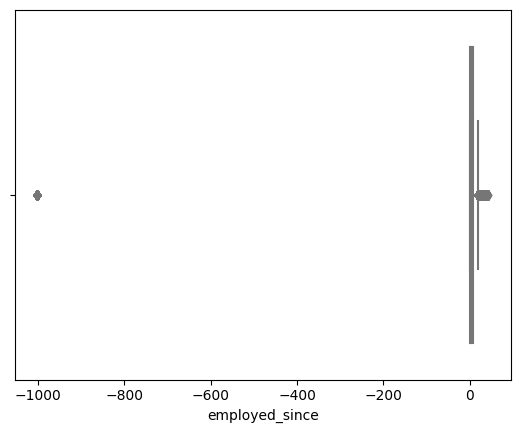

In [49]:
sns.boxplot(x = application_num['employed_since'])

In [50]:
# Checking those negative values: 
application_num['days_employed'].value_counts() # there are several values that do not fit. But might not be outliers. 

 365243    6135
-401         78
-1539        64
-200         63
-1678        61
           ... 
-2160         1
-2007         1
-758          1
-1289         1
-8894         1
Name: days_employed, Length: 3640, dtype: int64

In [51]:
# I am going to replace the negative values with the mean of the column: 

application_num[application_num['employed_since'] < 0] = np.nan
years_mean = math.floor(application_num['employed_since'].mean())
application_num['employed_since'].fillna(years_mean, inplace = True)

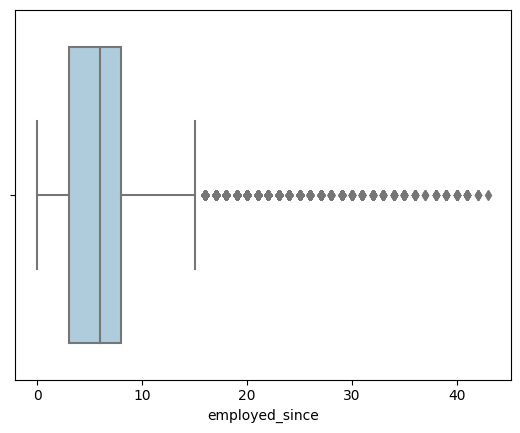

<AxesSubplot:xlabel='employed_since', ylabel='Count'>

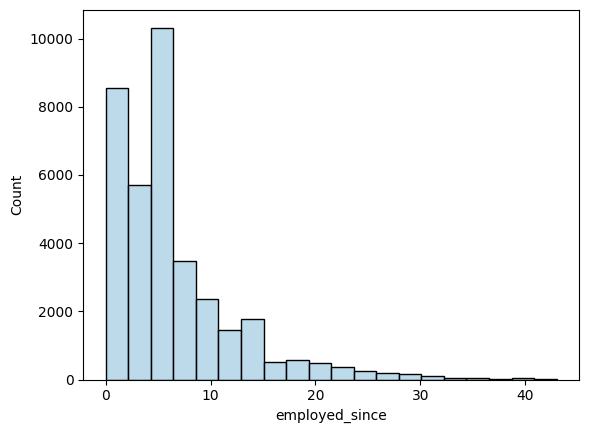

In [52]:
sns.boxplot(x = application_num['employed_since'])
plt.show()
sns.histplot(x = application_num['employed_since'], bins=20 )

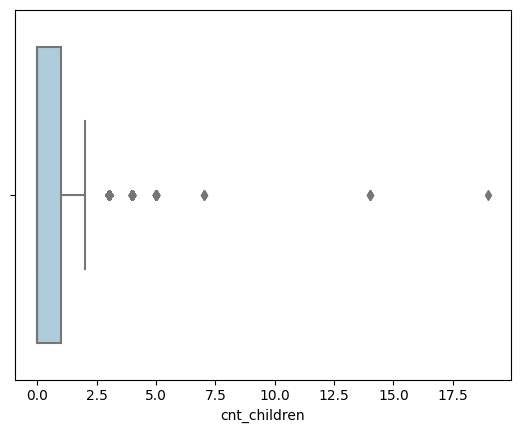

In [53]:
# CHILDREN

sns.boxplot(x = application_num['cnt_children']) # There seems to be some unusally high number of children in the data set

# OUTLIER

application_num = application_num.loc[application_num['cnt_children'] < 15]


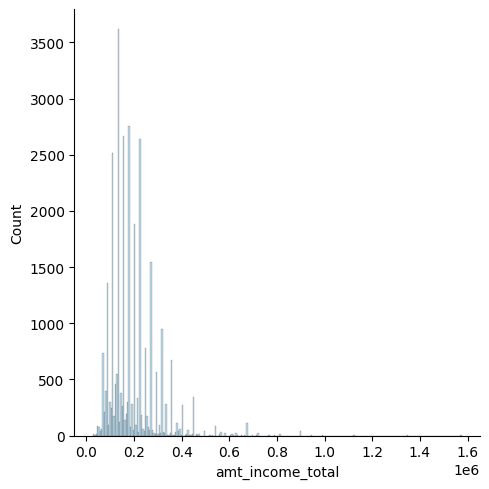

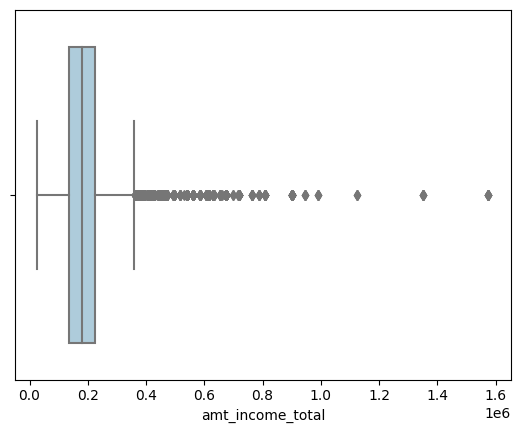

135000.0    3600
180000.0    2742
157500.0    2661
225000.0    2629
112500.0    2346
            ... 
151200.0       1
257625.0       1
204750.0       1
91530.0        1
164250.0       1
Name: amt_income_total, Length: 211, dtype: int64

In [54]:
# INCOME

sns.displot(x = application_num['amt_income_total'])
plt.show()
sns.boxplot(x = application_num['amt_income_total'])
plt.show()

application_num['amt_income_total'].value_counts()

In [55]:
# Removong the outliers: 
application_num = application_num.loc[application_num['amt_income_total'] < 500000]

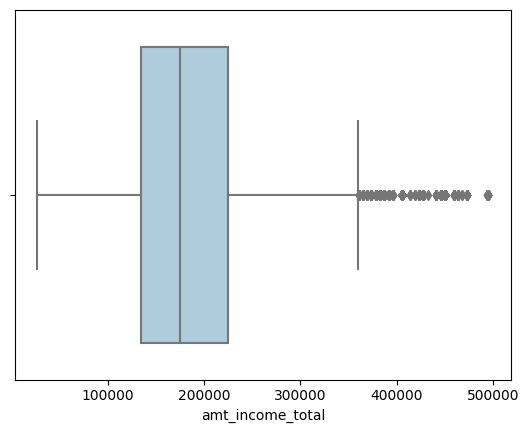

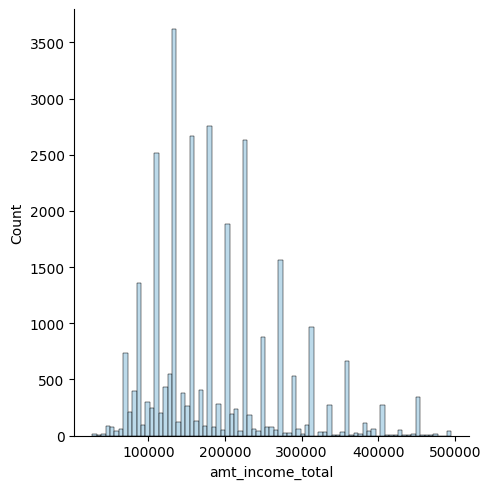

In [56]:
sns.boxplot(x= application_num['amt_income_total'])
plt.show()
sns.displot(x = application_num['amt_income_total'])

In [57]:
# Changing Income to a categorical values: 

# CHECKING FOR APPROPRIATE BIN SIZE: 
pd.cut(x=application_num['amt_income_total'], bins = 6)

0        (417000.0, 495000.0]
1        (417000.0, 495000.0]
2        (105000.0, 183000.0]
3        (261000.0, 339000.0]
4        (261000.0, 339000.0]
                 ...         
36452    (105000.0, 183000.0]
36453    (105000.0, 183000.0]
36454    (105000.0, 183000.0]
36455    (105000.0, 183000.0]
36456    (183000.0, 261000.0]
Name: amt_income_total, Length: 29870, dtype: category
Categories (6, interval[float64, right]): [(26532.0, 105000.0] < (105000.0, 183000.0] < (183000.0, 261000.0] < (261000.0, 339000.0] < (339000.0, 417000.0] < (417000.0, 495000.0]]

In [58]:
#Create customized bins: 
bins = [0,  100000, 200000, 300000, 400000, 500000]
labels = ['<=100k', '100k-200k', '200k-300k', '300k-400k', '400k+' ]

# Add column to categorical df
application_cat['income'] = pd.cut(x = application_num['amt_income_total'], bins = bins, labels = labels, include_lowest = True)



<AxesSubplot:xlabel='income', ylabel='Count'>

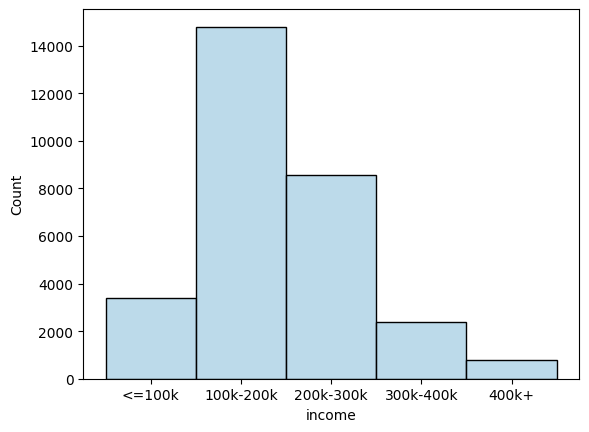

In [59]:
sns.histplot(application_cat['income'])

In [60]:
# DROP REDUNDANT DATA
application_num.drop(['flag_mobil', 'flag_work_phone', 'flag_phone', 'flag_email', 'amt_income_total', 'days_employed'], axis = 1, inplace = True)

In [61]:
application_num.to_csv('../../slides/numerical_after.csv')

In [62]:
application_cat.isna().sum()

code_gender               0
flag_own_car              0
flag_own_realty           0
name_income_type          0
name_education_type       0
name_family_status        0
name_housing_type         0
occupation_type           0
id                        0
flag_mobil                0
flag_work_phone           0
flag_phone                0
flag_email                0
income                 6587
dtype: int64

In [63]:
# DROPPING THE CATEGORICAL ROWS, THAT ARE NOW NULL VALUES. 
# those are the rows that where dropped due to the outlier cleaning in the numerical values

application_cat.dropna(inplace=True) # Now both df (numerical and categorical have the same length and can be merged)

# 2.  Feature Selection & Multicollinearity

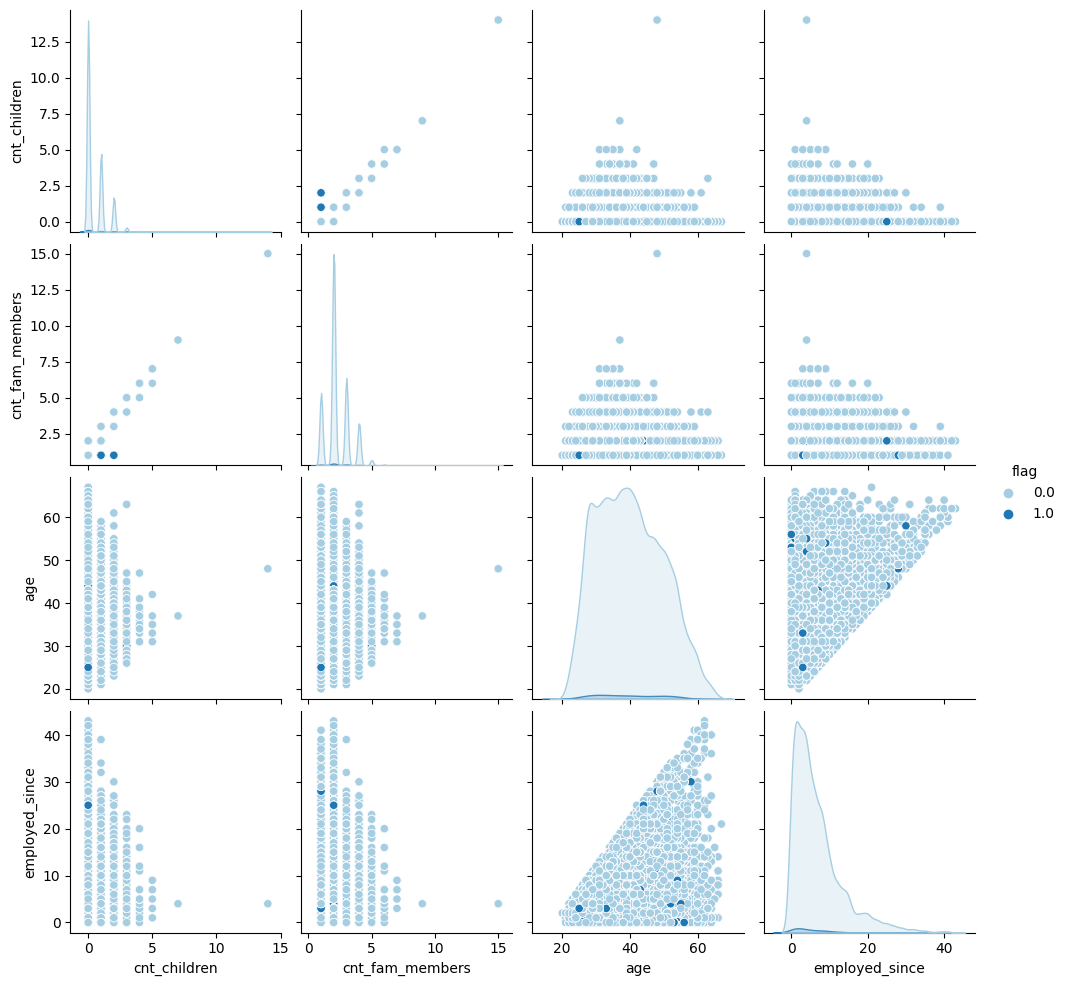

In [64]:
plot_data = application_num.drop('id', axis= 1)
sns.pairplot(plot_data, hue = 'flag')

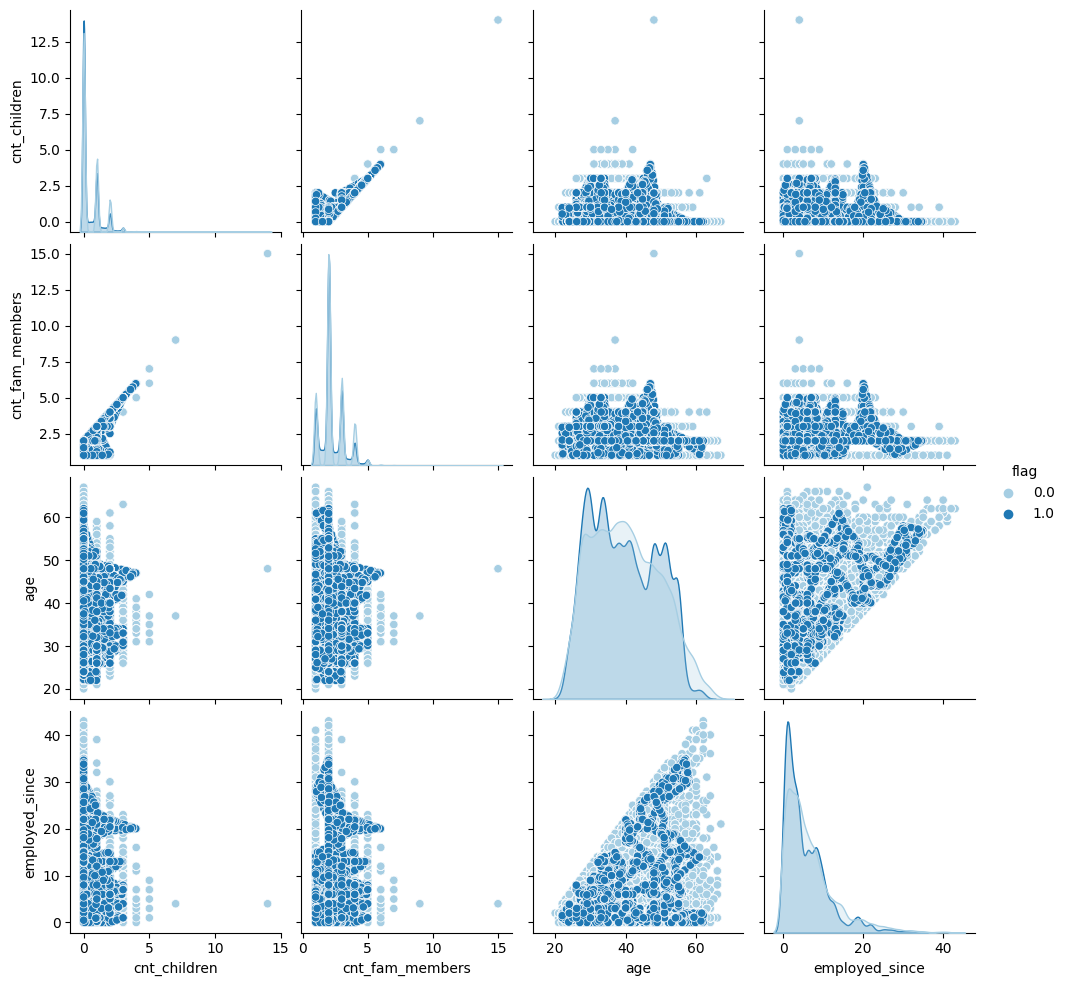

In [65]:
# SMOTE to Compare
from imblearn.over_sampling import SMOTE

X = plot_data.loc[:, plot_data.columns != 'flag']
y = plot_data['flag']
sm = SMOTE(random_state = 22)
X_res, y_res = sm.fit_resample(X, y)
data = pd.concat((X_res, y_res), axis = 1)

sns.pairplot(data, hue = 'flag')

#### Correlation Matrix

                 cnt_children  cnt_fam_members       age  employed_since
cnt_children         1.000000         0.900466 -0.257103       -0.061934
cnt_fam_members      0.900466         1.000000 -0.214155       -0.046103
age                 -0.257103        -0.214155  1.000000        0.343141
employed_since      -0.061934        -0.046103  0.343141        1.000000


<AxesSubplot:>

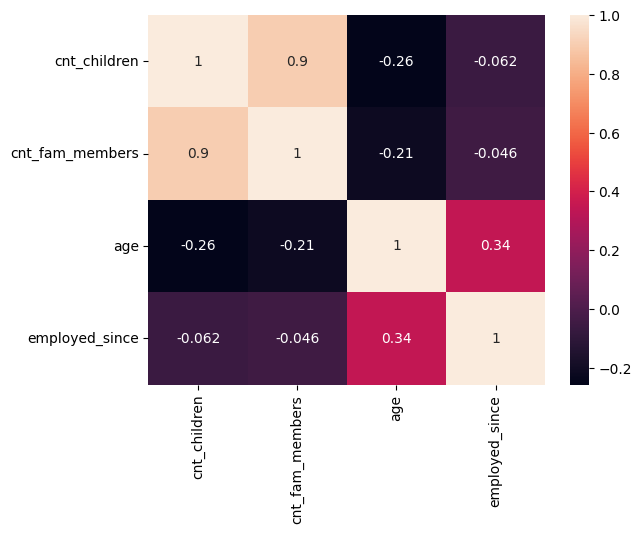

In [66]:
# Checking with Correlation Matrix on the not merged datafr for numerical values: 
features = application_num.drop(['id', 'flag'], axis= 1)
corr = features.corr()
print(corr)

sns.heatmap(corr, annot=True) # We can see a high correlation between the amount of children and family members

#### Variance Inflation Factor

In [67]:
# Checking with VIR

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif = pd.DataFrame()
    vif['features'] = df.columns
    vif['vif_value'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

calculate_vif(features)

,features,vif_value
0,cnt_children,6.069009
1,cnt_fam_members,20.829086
2,age,11.884177
3,employed_since,2.346841


In [68]:
# Removing highly multicollinearity data: 
application_num.drop('cnt_fam_members', axis = 1, inplace = True)

# 3. Data Preperation for Model

In [69]:
#Combining Dataframes: 

X_target = pd.merge(application_num, var_dep, on = 'id')
X_target.drop('flag_x', axis = 1, inplace = True)

In [70]:
X_target = pd.merge(application_cat, X_target, on='id')

# Split into X and Y:
y = pd.DataFrame(X_target['flag_y'])
X = X_target.iloc[:, X_target.columns != 'flag_y']
X['income'] = X['income'].astype('object')
# rename the Target Value
y.rename(columns = {'flag_y': 'target'}, inplace = True)


## Train Test Split

## Train Test Split

In [71]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 22)
X_train = pd.DataFrame(X_train).reset_index()
X_test = pd.DataFrame(X_test).reset_index()
y_train
y_test 

X_train = X_train.drop('id', axis = 1)
X_test = X_test.drop('id', axis = 1)

## Encoding Categorical 

In [72]:
X_train_cat = X_train.select_dtypes('object')
X_test_cat = X_test.select_dtypes('object')


In [73]:
# ONE HOT ENCODER 
from sklearn.preprocessing import OneHotEncoder

# Encoding TRAIN DATA
enc = OneHotEncoder(drop='first',)
X_train_encoded = enc.fit_transform(X_train_cat).toarray()


with open("../../encoders/one_hot_encoder.pkl", "wb") as file:
    pickle.dump(enc, file)

X_train_cat_encoded = pd.DataFrame(X_train_encoded, columns = enc.get_feature_names_out())

# Encoding TEST DATA
X_test_cat_encoded = enc.transform(X_test_cat).toarray()
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, columns = enc.get_feature_names_out())

In [74]:
# Adding to Dataframe: 
X_train = pd.concat([X_train, X_train_cat_encoded ], axis = 1)
X_train = X_train.drop(X_train_cat, axis = 1)

X_test = pd.concat([X_test, X_test_cat_encoded ], axis = 1)
X_test= X_test.drop(X_train_cat, axis = 1)

## CHI2 Test of Categorical and Target Values

In [75]:
# Dealing with imbalanced Data

from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train_cat_encoded, y_train['target'])



In [76]:
# Chi2 test
from sklearn.feature_selection import chi2

f_p_val = chi2(X_res, y_res)

print(f_p_val)

p_values = pd.Series(f_p_val[1])
p_values.index=X_train_cat_encoded.columns
chi2_pval = pd.DataFrame(p_values.sort_values(ascending = True))
chi2_pval = chi2_pval.rename(columns = {0: 'pval'})
chi2_pval.loc[chi2_pval['pval'] < 0.005, 'select'] = int(1)
chi2_pval.loc[chi2_pval['pval'] >= 0.005, 'select'] = int(0)

chi2_pval

features_chi2_df = chi2_pval.loc[chi2_pval['select'] == 1.0]
no_features_chi2_df = chi2_pval.loc[chi2_pval['select'] == 0.0]
features_chi2_list = features_chi2_df.index.values.tolist()


no_features_chi2_list = no_features_chi2_df.index.values.tolist()
no_features_chi2_list

chi2_pval

(array([7.43369911e+01, 4.89610295e+00, 3.55453218e+01, 4.30709388e+02,
       2.86180784e+01, 5.25797729e+00, 1.79766727e+01, 7.60357575e-02,
       1.00546530e+01, 1.49096468e+01, 8.30941243e+01, 1.06604034e-01,
       9.56464413e+01, 5.06407004e+01, 4.33333609e+01, 2.62710267e+01,
       3.41094253e+01, 7.19872876e+01]), array([6.58578229e-18, 2.69173742e-02, 2.49184779e-09, 1.13891154e-95,
       8.81552962e-08, 2.18463945e-02, 2.23628700e-05, 7.82743300e-01,
       1.51963642e-03, 1.12784769e-04, 7.82378989e-20, 7.44044022e-01,
       1.37346369e-22, 1.10920783e-12, 4.61645218e-11, 2.96706691e-07,
       5.20983055e-09, 2.16588181e-17]))


,pval,select
name_income_type_Others,1.138912e-95,1.0
occupation_type_Office Staff,1.373464e-22,1.0
name_housing_type_With parents,7.823790e-20,1.0
code_gender_M,6.585782e-18,1.0
income_<=100k,2.165882e-17,1.0
occupation_type_Others,1.109208e-12,1.0
income_200k-300k,4.616452e-11,1.0
flag_own_realty_Y,2.491848e-09,1.0
income_400k+,5.209831e-09,1.0
name_income_type_State servant,8.815530e-08,1.0


In [77]:
# CHECKING SUITABLE TRANSFORMATION
from sklearn.preprocessing import PowerTransformer, StandardScaler

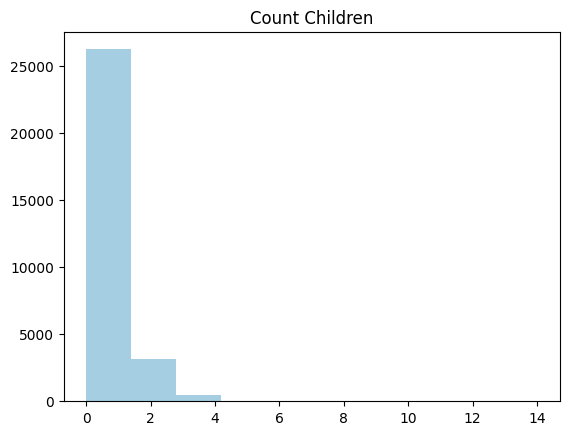

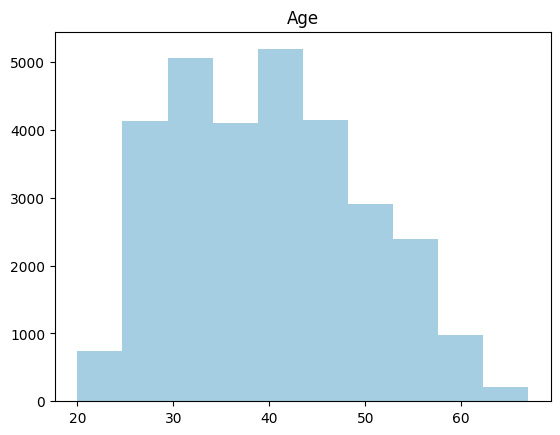

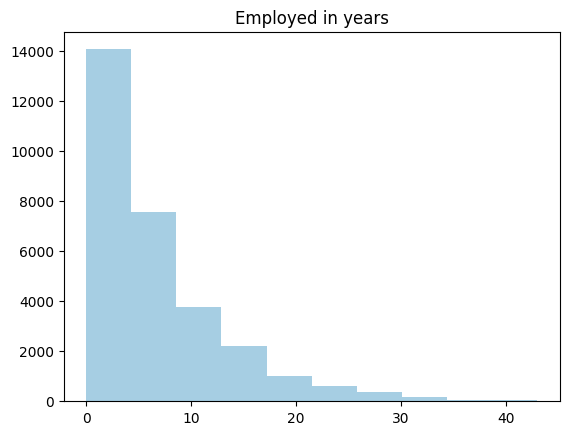

In [78]:
# CHECKING DISTRIBUTION
plt.title('Count Children')
plt.hist(application_num['cnt_children'])
plt.show()
plt.title('Age')
plt.hist(application_num['age'])
plt.show()
plt.title('Employed in years')
plt.hist(application_num['employed_since'])
plt.show()

In [79]:
#POWERTRANSFORMER
import pickle
trans = PowerTransformer()
age_employed_train_trans = trans.fit_transform(X_train[["age","employed_since"]]) #Train fit() transform()
age_employed_test_trans = trans.transform(X_test[['age', 'employed_since']]) #Test transform()

#Save Transformer
with open("../../transformers/power_transformer_age_employed.pkl", "wb") as file:
    pickle.dump(trans, file)

In [80]:
#DataFrame
age_empl_train_trans = pd.DataFrame(age_employed_train_trans, columns = ['age', 'employed'])
age_empl_test_trans = pd.DataFrame(age_employed_test_trans, columns = ['age', 'employed'])
#Cast into list
age_train = age_empl_train_trans['age'].tolist()
employed_train = age_empl_train_trans['employed'].tolist()
age_test = age_empl_test_trans['age'].tolist()
employed_test = age_empl_test_trans['employed'].tolist()

(array([[ 264.,  960., 2905., 3555., 2968., 4009., 2770., 2427.,  965.,
           86.],
        [   0., 1747., 2281., 1895., 5317., 3868., 3018., 1540., 1013.,
          230.]]),
 array([-2.51494573, -1.99724764, -1.47954955, -0.96185146, -0.44415337,
         0.07354472,  0.59124281,  1.1089409 ,  1.62663899,  2.14433708,
         2.66203517]),
 <a list of 2 BarContainer objects>)

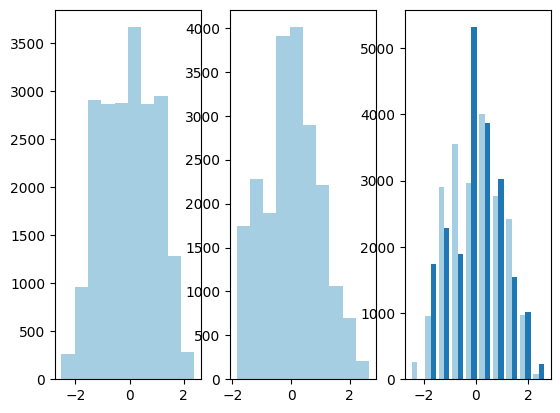

In [81]:
#Plot transformed data:
plt.subplot(1,3,1)
plt.hist(age_empl_train_trans['age'])
plt.subplot(1,3,2)
plt.hist(age_empl_train_trans['employed'])
plt.subplot(1,3,3)
plt.hist(age_empl_train_trans)

In [82]:
# STANDARDSCALER
scaler = StandardScaler()

# Train fit() transform()
children_train_scaled = scaler.fit_transform(X_train[['cnt_children']])

# Test transform()
children_test_scaled = scaler.transform(X_test[['cnt_children']])

with open("../../scalers/standard_scaler_cnt_children.pkl", "wb") as file:
    pickle.dump(scaler, file)

In [83]:
# Adding transformed data to df

X_train['cnt_children'] = children_train_scaled
X_train['age'] = age_train
X_train['employed_since'] = employed_train

X_test['cnt_children'] = children_test_scaled
X_test['age'] = age_test
X_test['employed_since'] = employed_test

In [84]:
X_train = X_train.drop('index', axis = 1)
X_test = X_test.drop('index', axis = 1)

## Upsampling SMOTE

<AxesSubplot:xlabel='target', ylabel='count'>

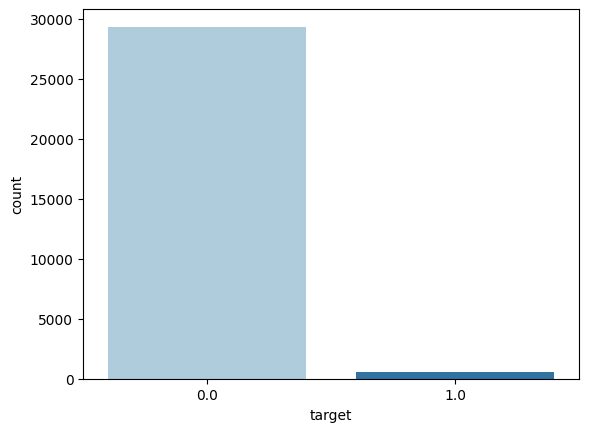

In [85]:
# Checking Class Imbalance 
y.value_counts()
sns.countplot(x = y['target'])

In [86]:
# SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 22)
X_res_train, y_res_train = sm.fit_resample(X_train, y_train['target'])


# 4. Prediction Model

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, cohen_kappa_score, roc_curve

## 4.1 Logistic Regression

In [88]:
clr = LogisticRegression(random_state = 22, solver = 'lbfgs').fit(X_res_train, y_res_train)

y_predict = clr.predict(X_test)

#Modal Score of Train Data
print('The modal score of the train data is {:.2f} \n'.format(clr.score(X_res_train, y_res_train)))

#Kappa Score of Test Data: 
print('The Kappe Score for the Prediction is {:.2f}\n'.format(cohen_kappa_score(y_test, y_predict)))
print(classification_report(y_test, y_predict))

confusion_matrix(y_test, y_predict)


The modal score of the train data is 0.61 

The Kappe Score for the Prediction is 0.00

              precision    recall  f1-score   support

         0.0       0.98      0.60      0.74      8791
         1.0       0.02      0.46      0.04       170

    accuracy                           0.59      8961
   macro avg       0.50      0.53      0.39      8961
weighted avg       0.96      0.59      0.73      8961



array([[5234, 3557],
       [  92,   78]])

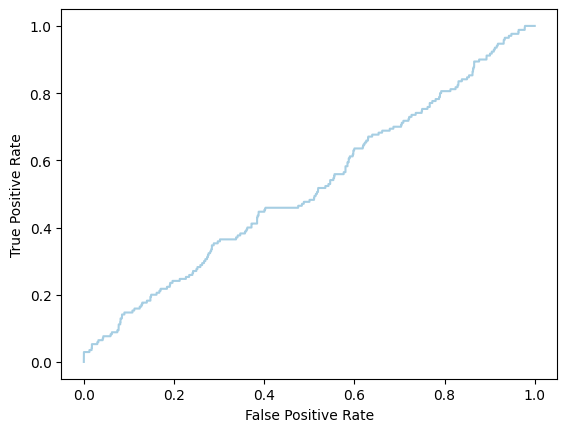

In [89]:
#Roc Curve
proba = clr.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [90]:
# Logistic Regression with the Selected Features from the Chi2 Test: 


X_train_wdrop = X_res_train.drop(no_features_chi2_list, axis = 1)
X_test_wdrop = X_test.drop(no_features_chi2_list, axis = 1)

clr = LogisticRegression(random_state = 22, solver = 'lbfgs').fit(X_train_wdrop, y_res_train)
y_predict = clr.predict(X_test_wdrop)

#Modal Score of Train Data
print('The modal score of the train data is {:.2f} \n'.format(clr.score(X_train_wdrop, y_res_train)))

#Kappa Score of Test Data: 
print('The Kappe Score for the Prediction is {:.2f}\n'.format(cohen_kappa_score(y_test, y_predict)))

print(classification_report(y_test, y_predict))

## This seems to yield worse outcome for this model! I will stick to the whole data

The modal score of the train data is 0.59 

The Kappe Score for the Prediction is 0.00

              precision    recall  f1-score   support

         0.0       0.98      0.57      0.72      8791
         1.0       0.02      0.44      0.04       170

    accuracy                           0.56      8961
   macro avg       0.50      0.50      0.38      8961
weighted avg       0.96      0.56      0.71      8961



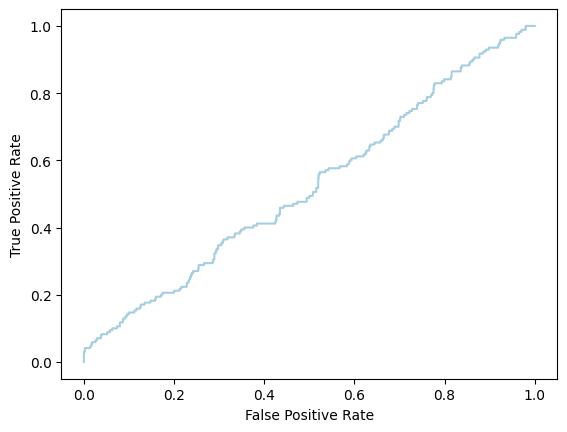

In [91]:
#Roc Curve
proba = clr.predict_proba(X_test_wdrop)[::,1]
fpr, tpr, _ = roc_curve(y_test,  proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## 4.2 KNeighbors


Text(0, 0.5, 'Accuracy')

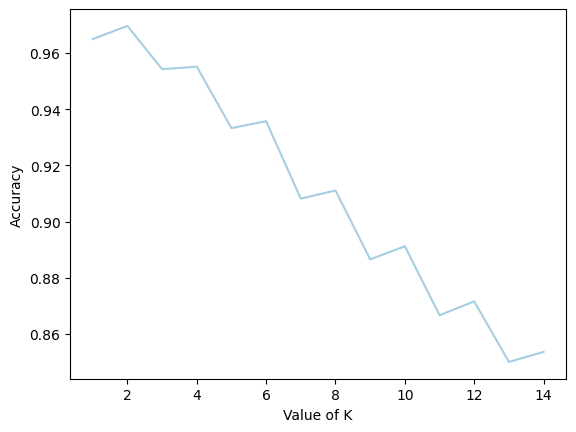

In [92]:
# Checking the Accuracy Score for n in range (1, 15)

range_k = range(1,15)
scores = {}
scores_list = []
for k in range_k:
   classifier = KNeighborsClassifier(n_neighbors=k)
   classifier.fit(X_res_train, y_res_train)
   y_pred = classifier.predict(X_test)
   scores[k] = accuracy_score(y_test,y_pred)
   scores_list.append(accuracy_score(y_test,y_pred))


plt.plot(range_k,scores_list)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")

The accuracy score with n = 2 is 0.970

The Kappe Score for the Prediction is 0.18



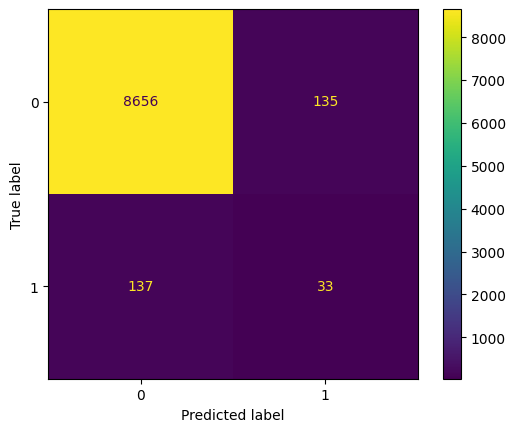


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      8791
         1.0       0.20      0.19      0.20       170

    accuracy                           0.97      8961
   macro avg       0.59      0.59      0.59      8961
weighted avg       0.97      0.97      0.97      8961



In [93]:
# KNeighbors n = 2

neigh = KNeighborsClassifier(n_neighbors = 2)
neigh.fit(X_res_train, y_res_train)
y_predict = neigh.predict(X_test)
print('The accuracy score with n = 2 is {:.3f}'.format(accuracy_score(y_test, y_predict)))

# Kappa Score of Test Data: 
print('\nThe Kappe Score for the Prediction is {:.2f}\n'.format(cohen_kappa_score(y_test, y_predict)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
dis = ConfusionMatrixDisplay(cm).plot()
plt.show()

print()
print(classification_report(y_test, y_predict))

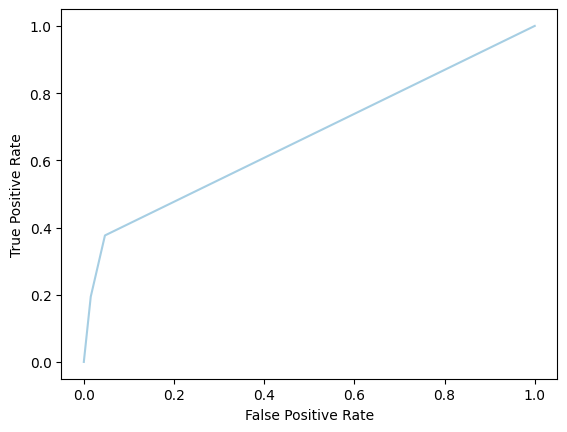

In [94]:
#Roc Curve
proba = neigh.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



The accuracy score with n = 3 is 0.954


The Kappe Score for the Prediction is 0.18



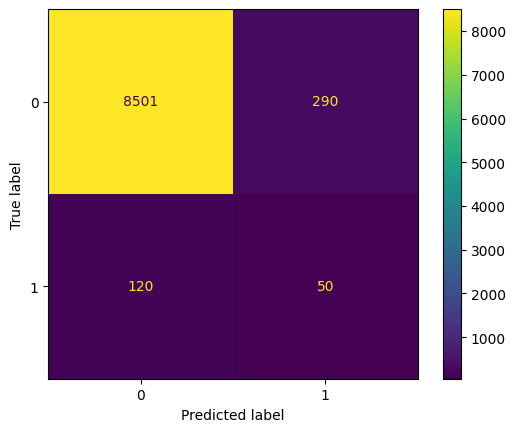


              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      8791
         1.0       0.15      0.29      0.20       170

    accuracy                           0.95      8961
   macro avg       0.57      0.63      0.59      8961
weighted avg       0.97      0.95      0.96      8961



In [95]:
# KNeighbors n = 3 

neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(X_res_train, y_res_train)
y_predict = neigh.predict(X_test)
accuracy_score(y_test, y_predict)
print()
print('The accuracy score with n = 3 is {:.3f}'.format(accuracy_score(y_test, y_predict)))
print()

# Kappa Score of Test Data: 
print('\nThe Kappe Score for the Prediction is {:.2f}\n'.format(cohen_kappa_score(y_test, y_predict)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
dis = ConfusionMatrixDisplay(cm).plot()
plt.show()

print()
print(classification_report(y_test, y_predict))

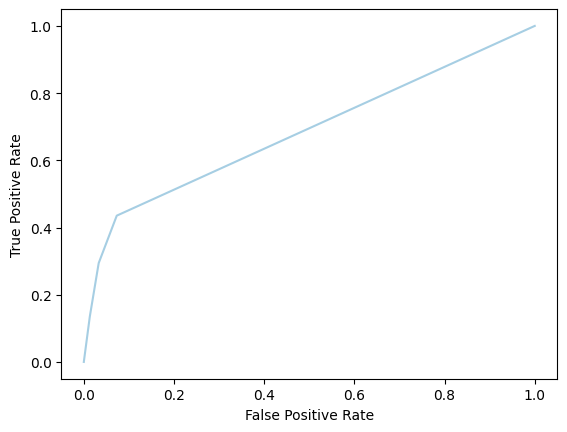

In [96]:
#Roc Curve
proba = neigh.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



The accuracy score with n = 4 is 0.955


The Kappe Score for the Prediction is 0.14



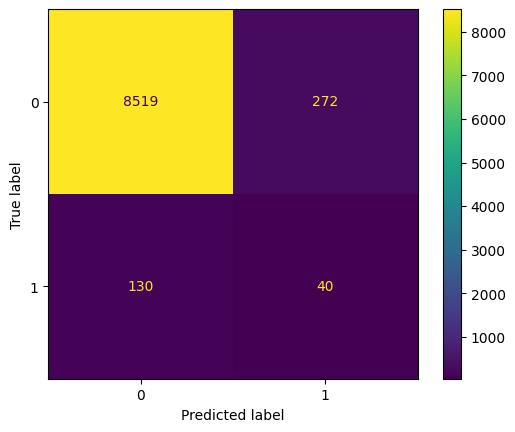


              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      8791
         1.0       0.13      0.24      0.17       170

    accuracy                           0.96      8961
   macro avg       0.56      0.60      0.57      8961
weighted avg       0.97      0.96      0.96      8961



In [97]:
# KNeighbors n = 4

neigh = KNeighborsClassifier(n_neighbors = 4)
neigh.fit(X_res_train, y_res_train)
y_predict = neigh.predict(X_test)
accuracy_score(y_test, y_predict)
print()
print('The accuracy score with n = 4 is {:.3f}'.format(accuracy_score(y_test, y_predict)))
print()

# Kappa Score of Test Data: 
print('\nThe Kappe Score for the Prediction is {:.2f}\n'.format(cohen_kappa_score(y_test, y_predict)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
dis = ConfusionMatrixDisplay(cm).plot()
plt.show()

print()
print(classification_report(y_test, y_predict))

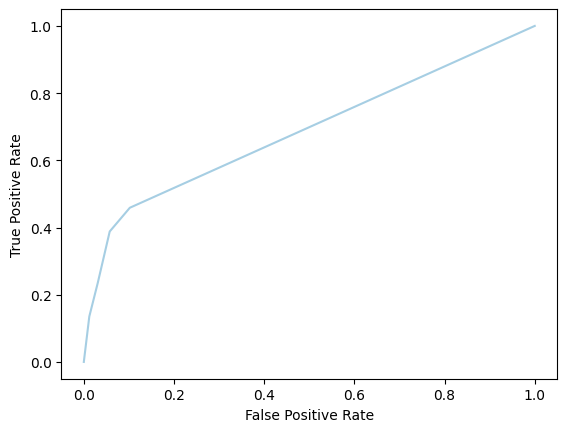

In [98]:
#Roc Curve
proba = neigh.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



The accuracy score with n = 3 is 0.954


The Kappe Score for the Prediction is 0.17



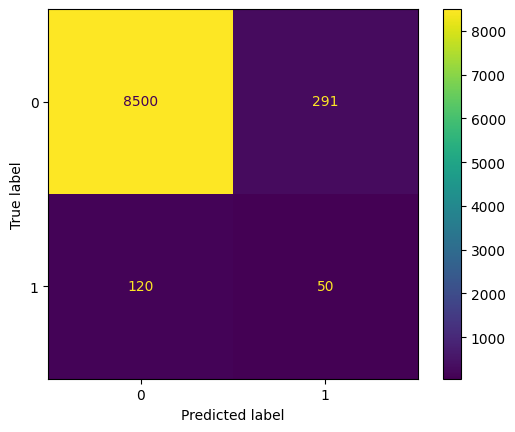


              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      8791
         1.0       0.15      0.29      0.20       170

    accuracy                           0.95      8961
   macro avg       0.57      0.63      0.59      8961
weighted avg       0.97      0.95      0.96      8961



In [99]:
# TESTING THE MODEL WITH SELECTE FEATURES ONLY: 

X_res_train_small = X_res_train.drop(no_features_chi2_list, axis = 1)
X_test_small = X_test.drop(no_features_chi2_list, axis = 1)
# KNeighbors n = 3 

neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(X_res_train_small, y_res_train)
y_predict = neigh.predict(X_test_small)
accuracy_score(y_test, y_predict)
print()
print('The accuracy score with n = 3 is {:.3f}'.format(accuracy_score(y_test, y_predict)))
print()

# Kappa Score of Test Data: 
print('\nThe Kappe Score for the Prediction is {:.2f}\n'.format(cohen_kappa_score(y_test, y_predict)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
dis = ConfusionMatrixDisplay(cm).plot()
plt.show()

print()
print(classification_report(y_test, y_predict))

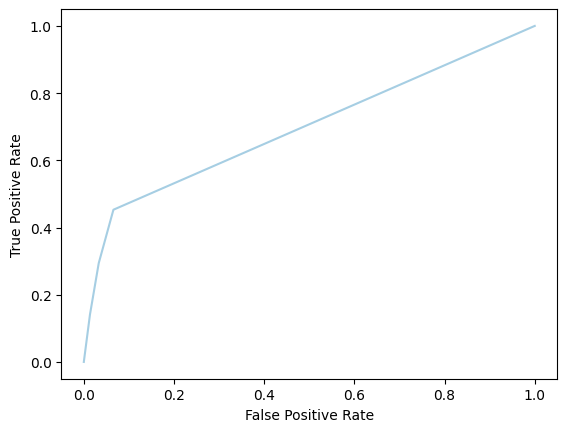

In [100]:
#Roc Curve
proba = neigh.predict_proba(X_test_small)[::,1]
fpr, tpr, _ = roc_curve(y_test,  proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## 4.3 Decision Tree Classifier


The Model Accuracy Score for the test set = 0.97

The Model Precission Score for the test set = 0.31 

The Classification Report for the Decision Tree Classifier: 

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      8791
         1.0       0.31      0.31      0.31       170

    accuracy                           0.97      8961
   macro avg       0.65      0.65      0.65      8961
weighted avg       0.97      0.97      0.97      8961



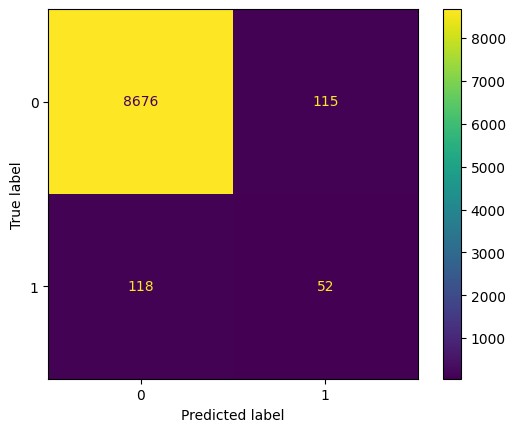

In [101]:
from sklearn import tree
clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 22).fit(X_res_train, y_res_train)

# Prediction
prediction = clf.predict(X_test)
# Prediction Probability
proba = clf.predict_proba(X_test)

# Accuracy and Precision Score
print('\nThe Model Accuracy Score for the test set = {:.2f}'.format(accuracy_score(y_test, prediction)))
print('\nThe Model Precission Score for the test set = {:.2f} \n'.format(precision_score(y_test, prediction)))

# Confusion Matrix
cm = confusion_matrix(y_test, prediction)
ConfusionMatrixDisplay(cm).plot()

print('The Classification Report for the Decision Tree Classifier: \n')
print(classification_report(y_test, prediction))

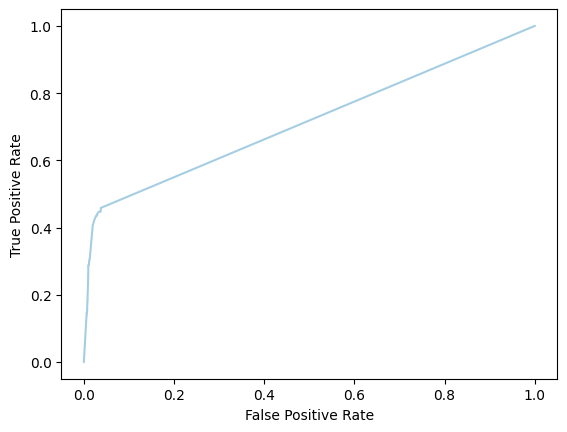

In [102]:
#Roc Curve
proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


<AxesSubplot:>

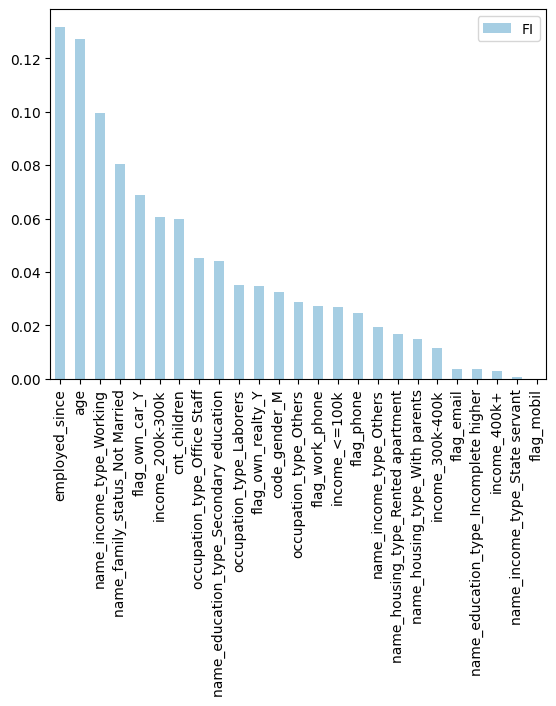

In [103]:
# Checking the Importance of the individual features for the Decistion Tree:

clf.feature_importances_

feature_names = X_train.columns.tolist()

feature_importance = pd.DataFrame(clf.feature_importances_, index = feature_names)
feature_importance = feature_importance.rename(columns = {0:'FI'})
feature_importance = feature_importance.sort_values(by='FI', ascending = False)


feature_importance.plot(kind = 'bar')


The Model Accuracy Score with max_depth(4) = 0.81

The Model Precission Score with max_depth(4) = 0.02 



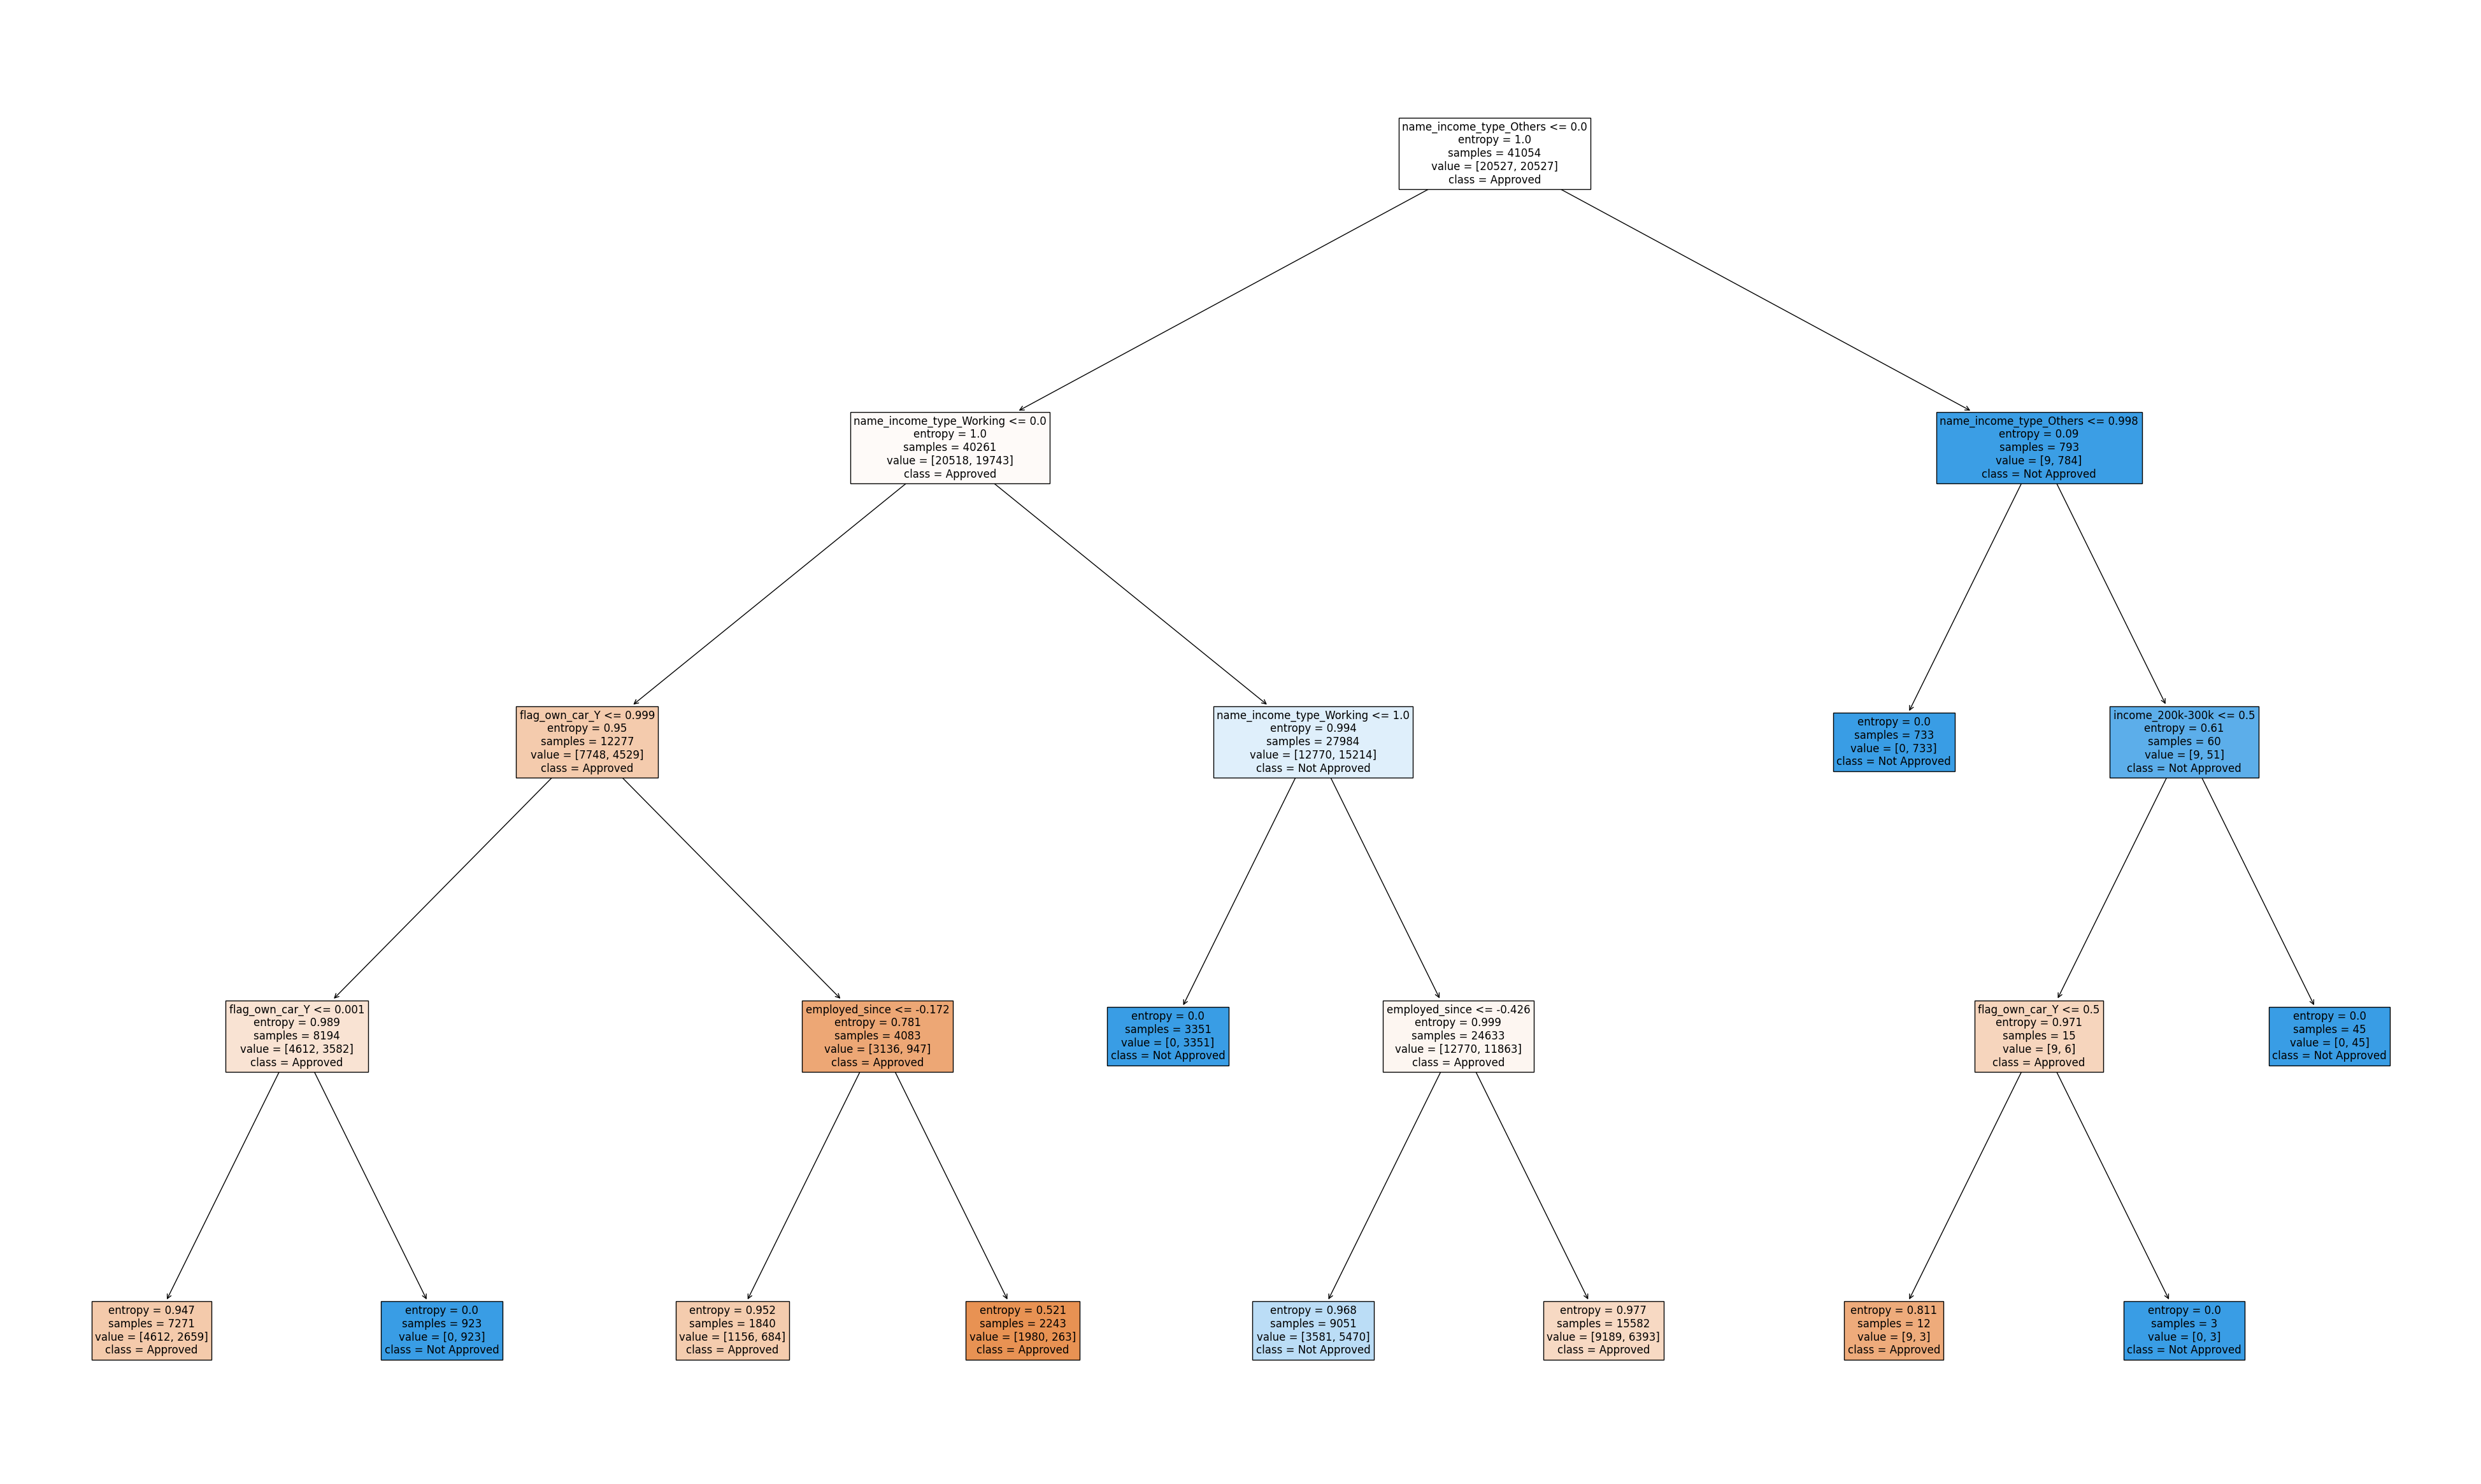

In [104]:
#Limit Max Depth to 4: 
clf = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy', random_state = 22).fit(X_res_train, y_res_train)


# Prediction
prediction = clf.predict(X_test)
# Prediction Probability
proba = clf.predict_proba(X_test)

# Accuracy and Precision Score
print('\nThe Model Accuracy Score with max_depth(4) = {:.2f}'.format(accuracy_score(y_test, prediction)))
print('\nThe Model Precission Score with max_depth(4) = {:.2f} \n'.format(precision_score(y_test, prediction)))

#Tree Plot for Max Depth 4
fig = plt.figure(figsize = (50,30))
_ = tree.plot_tree(clf, 
                  feature_names = feature_names,
                  class_names = {0: 'Approved', 1: 'Not Approved'},
                  filled=True,
                  fontsize = 12)